In [1014]:
#import important module
import sqlite3 as db
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels import tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
%matplotlib inline

In [2]:
#Make a connection to the database
def database_connection():
    global conn, cur
    try:
        conn=db.connect('olist.db')
        cur=conn.cursor()
        print('Connected to SQLite')   
    except db.Error as error:
        print("Failed to update sqlite table", error)
    finally :
        return conn, cur

In [3]:
database_connection()

Connected to SQLite


(<sqlite3.Connection at 0x7fe2b3ca37b0>, <sqlite3.Cursor at 0x7fe2b3cc3e30>)

# Check all table in olist.db

In [4]:
#Show table_name
query='''
SELECT 
    name
FROM 
    sqlite_schema
WHERE 
    type ='table'
'''

In [5]:
#Show all table in olist database
table_list=pd.read_sql_query(query,conn)
table_list

,name
0,olist_order_customer_dataset
1,olist_order_dataset
2,olist_order_reviews_dataset
3,olist_order_payments_dataset
4,olist_order_items_dataset
5,olist_products_dataset
6,olist_sellers_dataset
7,olist_geolocation_dataset
8,product_category_name_translation


In [6]:
#Check customer dataset
customer_query='''
SELECT
    *
FROM
   olist_order_customer_dataset
'''
customer_dataset=pd.read_sql_query(customer_query,conn)
customer_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   index                     99441 non-null  int64 
 1   customer_id               99441 non-null  object
 2   customer_unique_id        99441 non-null  object
 3   customer_zip_code_prefix  99441 non-null  int64 
 4   customer_city             99441 non-null  object
 5   customer_state            99441 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB


There is no nan value in this customer_table. The customer_id table must be unique. So duplicate check must be done in customer_id.

There is no duplicated data in customer_id table.

In [951]:
customer_dataset.isna().sum()

index                       0
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [950]:
customer_dataset['customer_id'].duplicated().sum()

0

In [898]:
city_customer_dataset=customer_dataset.groupby('customer_city').agg({'customer_unique_id':'count'}).sort_values('customer_unique_id',ascending=False)
city_customer_dataset=city_customer_dataset.rename(columns={'customer_unique_id':'number_of_customer'})
city_customer_dataset

,number_of_customer
customer_city,
sao paulo,15540
rio de janeiro,6882
belo horizonte,2773
brasilia,2131
curitiba,1521
...,...
ibiara,1
rio espera,1
rio dos indios,1


There are 96096 customer in Olist

In [9]:
repeat_order=customer_dataset[customer_dataset.duplicated(subset='customer_unique_id' ,keep=False)].sort_values('customer_unique_id')
new_repeat_order=repeat_order.groupby('customer_unique_id').agg({'customer_id':'count'}).sort_values('customer_id',ascending=False)

In [10]:
repeat_order_percentage=new_repeat_order.shape[0]/customer_dataset['customer_unique_id'].nunique()
print(f'There are only {repeat_order_percentage*100 :.3} % user that repeat order in olist' )

There are only 3.12 % user that repeat order in olist


In [329]:
city_repeat_order=repeat_order.groupby('customer_city').agg({'customer_unique_id':'count'}).sort_values('customer_unique_id',ascending=False)
city_repeat_order=city_repeat_order.rename(columns={'customer_unique_id':'number_of_repeat_order_customer'})
city_repeat_order

,number_of_repeat_order_customer
customer_city,
sao paulo,1084
rio de janeiro,510
belo horizonte,198
brasilia,126
curitiba,104
...,...
pomerode,1
planaltina,1
mariluz,1


<AxesSubplot:xlabel='customer_unique_id', ylabel='customer_city'>

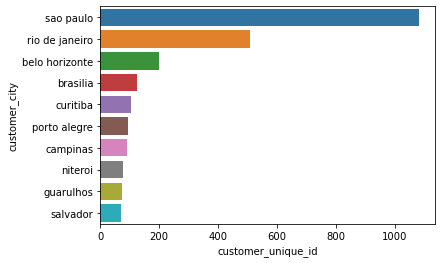

In [12]:
sns.barplot(data=city_repeat_order,y=city_repeat_order.head(10).index, x=city_repeat_order['customer_unique_id'].head(10))

In [13]:
#Check olist_order_dataset
order_query='''
SELECT
    *
FROM
   olist_order_dataset
'''
order_dataset=pd.read_sql_query(order_query,conn)
order_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          99441 non-null  int64 
 1   order_id                       99441 non-null  object
 2   customer_id                    99441 non-null  object
 3   order_status                   99441 non-null  object
 4   order_purchase_timestamp       99441 non-null  object
 5   order_approved_at              99281 non-null  object
 6   order_delivered_carrier_date   97658 non-null  object
 7   order_delivered_customer_date  96476 non-null  object
 8   order_estimated_delivery_date  99441 non-null  object
dtypes: int64(1), object(8)
memory usage: 6.8+ MB


In [902]:
order_dataset.isna().sum()

index                               0
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

- There is null value in column order_approved_at, order_delivered_carrier_date, order_delivered_customer_date. It must be related with order status. If order status is not delivered, the date of order_delivered_customer_date will be null. And so on.
- Customer_id and order_id are the column those must be unique. Check duplicated data in both column are needed.

There is no duplicated data in both column

In [14]:
order_dataset.duplicated(subset=['customer_id','order_id']).sum()

0

<AxesSubplot:xlabel='count', ylabel='order_status'>

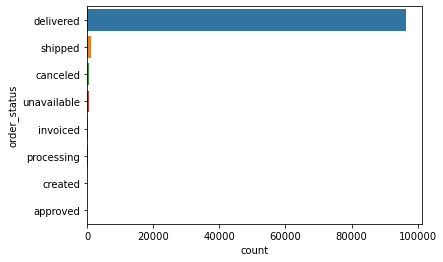

In [15]:
sns.countplot(y=order_dataset['order_status'],order=order_dataset['order_status'].value_counts().iloc[:10].index)

Most of order status is delivered

In [910]:
data_delivered=order_dataset[order_dataset['order_status']=='delivered']
data_delivered.isna().sum()

index                             0
order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [912]:
data_delivered[data_delivered['order_delivered_customer_date'].isna()]

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,None,2017-12-18 00:00:00
20618,20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,None,2018-07-16 00:00:00
43834,43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,None,2018-07-30 00:00:00
79263,79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,None,2018-07-30 00:00:00
82868,82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,None,2018-07-24 00:00:00
92643,92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,None,None,2017-06-23 00:00:00
97647,97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,None,2018-06-26 00:00:00
98038,98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,None,2018-07-19 00:00:00


In [16]:
#Check olist_order_reviews_dataset
order_review_query='''
SELECT
    *
FROM
   olist_order_reviews_dataset
'''
reviews_dataset=pd.read_sql_query(order_review_query,conn)
reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   index                    99224 non-null  int64 
 1   review_id                99224 non-null  object
 2   order_id                 99224 non-null  object
 3   review_score             99224 non-null  int64 
 4   review_comment_title     11568 non-null  object
 5   review_comment_message   40977 non-null  object
 6   review_creation_date     99224 non-null  object
 7   review_answer_timestamp  99224 non-null  object
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


There is null value in review_comment_title and. review_comment_message. Review_id must be unique.

In [17]:
reviews_dataset[['review_id','order_id']].nunique()/reviews_dataset.shape[0]

review_id    0.991796
order_id     0.994447
dtype: float64

There are duplicated data in review_id and order_id

In [18]:
reviews_dataset[reviews_dataset['review_id'].duplicated(keep=False)].sort_values('review_id')

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
46678,46678,00130cbe1f9d422698c812ed8ded1919,dfcdfc43867d1c1381bfaf62d6b9c195,1,None,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07 00:00:00,2018-03-20 18:08:23
29841,29841,00130cbe1f9d422698c812ed8ded1919,04a28263e085d399c97ae49e0b477efa,1,None,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07 00:00:00,2018-03-20 18:08:23
90677,90677,0115633a9c298b6a98bcbe4eee75345f,78a4201f58af3463bdab842eea4bc801,5,None,None,2017-09-21 00:00:00,2017-09-26 03:27:47
63193,63193,0115633a9c298b6a98bcbe4eee75345f,0c9850b2c179c1ef60d2855e2751d1fa,5,None,None,2017-09-21 00:00:00,2017-09-26 03:27:47
92876,92876,0174caf0ee5964646040cd94e15ac95e,f93a732712407c02dce5dd5088d0f47b,1,None,Produto entregue dentro de embalagem do fornec...,2018-03-07 00:00:00,2018-03-08 03:00:53
...,...,...,...,...,...,...,...,...
31120,31120,fe5c833752953fed3209646f1f63b53c,4863e15fa53273cc7219c58f5ffda4fb,1,None,"Comprei dois produtos e ambos, mesmo enviados ...",2018-02-28 00:00:00,2018-02-28 13:57:52
7870,7870,ff2fc9e68f8aabfbe18d710b83aabd30,2da58e0a7dcfa4ce1e00fad9d03ca3b5,2,None,None,2018-03-17 00:00:00,2018-03-19 11:44:15
82521,82521,ff2fc9e68f8aabfbe18d710b83aabd30,1078d496cc6ab9a8e6f2be77abf5091b,2,None,None,2018-03-17 00:00:00,2018-03-19 11:44:15
73951,73951,ffb8cff872a625632ac983eb1f88843c,c44883fc2529b4aa03ca90e7e09d95b6,3,None,None,2017-07-22 00:00:00,2017-07-26 13:41:07


After i check the dataset. The comment seems like double post. So it need to be cleaned.

In [19]:
#Check olist_order_payments_dataset
order_payments_query='''
SELECT
    *
FROM
   olist_order_payments_dataset
'''
payments_dataset=pd.read_sql_query(order_payments_query,conn)
payments_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   index                 103886 non-null  int64  
 1   order_id              103886 non-null  object 
 2   payment_sequential    103886 non-null  int64  
 3   payment_type          103886 non-null  object 
 4   payment_installments  103886 non-null  int64  
 5   payment_value         103886 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 4.8+ MB


All column have no null value. Order_id can double because of one order_id can have two type of payment

<AxesSubplot:xlabel='payment_value', ylabel='Density'>

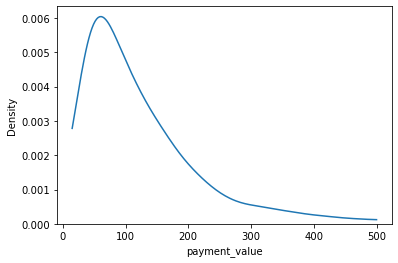

In [20]:
#Check distribution of payment amount
sns.kdeplot(payments_dataset['payment_value'],cut=0,clip=(15,500))

Most of payment is below 100 USD

In [929]:
#Check olist_order_items_dataset
order_items_query='''
SELECT
    *
FROM
   olist_order_items_dataset
'''
items_dataset=pd.read_sql_query(order_items_query,conn)
items_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                112650 non-null  int64  
 1   order_id             112650 non-null  object 
 2   order_item_id        112650 non-null  int64  
 3   product_id           112650 non-null  object 
 4   seller_id            112650 non-null  object 
 5   shipping_limit_date  112650 non-null  object 
 6   price                112650 non-null  float64
 7   freight_value        112650 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 6.9+ MB


In [935]:
items_dataset.columns

Index(['index', 'order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [943]:
items_dataset.isna().sum()

index                  0
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

All column have no null value. Order_id can be double because of one order_id more than one order_item_id, product_id, seller_id. 

<AxesSubplot:xlabel='price', ylabel='Density'>

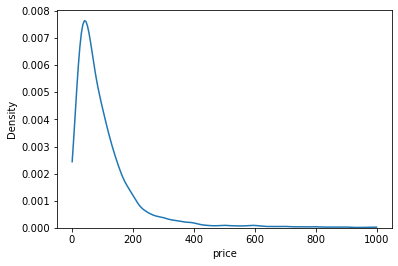

In [22]:
#Distribution of Price of Item
sns.kdeplot(items_dataset['price'],cut=0,clip=(0,1000))

Most of Item Price is below 200 USD

In [23]:
#Check olist_products_dataset
product_query='''
SELECT
    *
FROM
   olist_products_dataset
'''
products_dataset=pd.read_sql_query(product_query,conn)
products_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       32951 non-null  int64  
 1   product_id                  32951 non-null  object 
 2   product_category_name       32341 non-null  object 
 3   product_name_lenght         32341 non-null  float64
 4   product_description_lenght  32341 non-null  float64
 5   product_photos_qty          32341 non-null  float64
 6   product_weight_g            32949 non-null  float64
 7   product_length_cm           32949 non-null  float64
 8   product_height_cm           32949 non-null  float64
 9   product_width_cm            32949 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ MB


There are null value on product_category_name, product_name_lenght, product_description_lenght, product_weight_g, product_length_cm, product_height_cm, product_width_cm. product_id must be unique as identifier.

In [24]:
products_dataset['product_id'].duplicated().sum()

0

All data in product_id are unique

<AxesSubplot:title={'center':'20 Product Most Listed'}, xlabel='number_of_product', ylabel='product_category'>

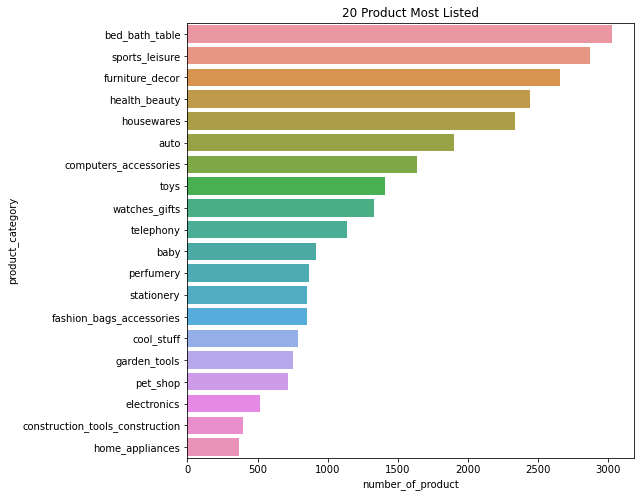

In [25]:
#Check Most Product Listed
check_product_query='''
SELECT
    eng.product_category_name_english AS product_category,
    COUNT (prod.product_id) AS number_of_product
    
FROM
   olist_products_dataset prod
JOIN
    product_category_name_translation eng
ON
    eng.product_category_name = prod.product_category_name
GROUP BY
   product_category 
ORDER BY
   number_of_product DESC 
'''
count_products=pd.read_sql_query(check_product_query,conn)
fig,ax=plt.subplots(figsize=(8,8))
ax.set_title('20 Product Most Listed')
count_products_selected=count_products.head(20)
sns.barplot(data=count_products_selected, y='product_category',x='number_of_product',ax=ax)

Bed_bath_table are most product that listed in olist

In [26]:
#Check olist_sellers_dataset
seller_query='''
SELECT
    *
FROM
   olist_sellers_dataset
'''
seller_dataset=pd.read_sql_query(seller_query,conn)
seller_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   3095 non-null   int64 
 1   seller_id               3095 non-null   object
 2   seller_zip_code_prefix  3095 non-null   int64 
 3   seller_city             3095 non-null   object
 4   seller_state            3095 non-null   object
dtypes: int64(2), object(3)
memory usage: 121.0+ KB


All column have no null value. Seller_id can't be double because of it's identifier of seller

In [27]:
seller_dataset['seller_id'].duplicated().sum()

0

There is no duplicated data in seller_id

<AxesSubplot:xlabel='count', ylabel='seller_city'>

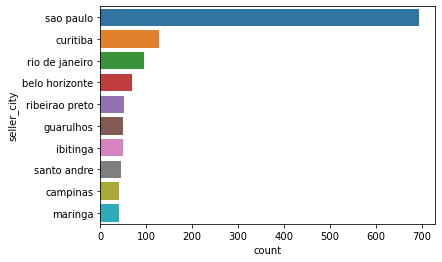

In [28]:
sns.countplot(y=seller_dataset['seller_city'],order=seller_dataset['seller_city'].value_counts().iloc[:10].index)

Most of seller is in sao paulo

In [29]:
#Check olist_geolocation_dataset
geo_query='''
SELECT
    *
FROM
   olist_geolocation_dataset
'''
geo_dataset=pd.read_sql_query(geo_query,conn)
geo_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 6 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   index                        1000163 non-null  int64  
 1   geolocation_zip_code_prefix  1000163 non-null  int64  
 2   geolocation_lat              1000163 non-null  float64
 3   geolocation_lng              1000163 non-null  float64
 4   geolocation_city             1000163 non-null  object 
 5   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 45.8+ MB


There is no null value in geolocation dataset

In [30]:
#Check product_category_name_translation
trans_query='''
SELECT
    *
FROM
   product_category_name_translation
'''
translation_dataset=pd.read_sql_query(trans_query,conn)
translation_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          71 non-null     int64 
 1   product_category_name          71 non-null     object
 2   product_category_name_english  71 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.8+ KB


There is No Null Value in translation dataset

# Analysis of Data

In [922]:
ana_order_query='''
WITH order_table AS (
SELECT 
    ord.customer_id,
    ord.order_id,
    strftime('%Y%m',ord.order_purchase_timestamp) AS month_year,
    COUNT(item.product_id) AS items_per_transaction
FROM
    olist_order_dataset ord
JOIN
    olist_order_items_dataset item
ON 
    item.order_id = ord.order_id 
WHERE
    ord.order_approved_at IS NOT NULL AND
    ord.order_delivered_carrier_date IS NOT NULL AND
    ord.order_delivered_customer_date IS NOT NULL AND
    ord.order_status = 'delivered'
GROUP BY
    ord.order_id
),
order_product_customer AS(
SELECT
    cus.customer_unique_id,
    ot.order_id,
    ot.month_year,
    ot.items_per_transaction    
FROM 
    order_table ot
JOIN 
    olist_order_customer_dataset cus
ON
    ot.customer_id = cus.customer_id
)
SELECT
    month_year,
    COUNT(order_id) AS number_of_success_transaction,
    COUNT(DISTINCT customer_unique_id) AS number_of_customer,
    SUM(items_per_transaction) AS items_sold,
    AVG(items_per_transaction) AS average_items_per_transaction
FROM
    order_product_customer
GROUP BY
    month_year
;
'''
order_table=pd.read_sql_query(ana_order_query,conn)
order_table['month_year']=pd.to_datetime(order_table['month_year'],format=('%Y%m'))
order_table

#Cleaning data when monthly transaction is only one and to make data continue
data = order_table.drop(index=[0,1,2])

#Set month as index
data=data.set_index('month_year')

#Add new metrics
data['transaction_per_customer']=data['number_of_success_transaction'] / data['number_of_customer']
data

,number_of_success_transaction,number_of_customer,items_sold,average_items_per_transaction,transaction_per_customer
month_year,,,,,
2017-01-01,748,716,911,1.217914,1.044693
2017-02-01,1641,1618,1845,1.124314,1.014215
2017-03-01,2546,2508,2897,1.137863,1.015152
2017-04-01,2303,2274,2569,1.115502,1.012753
2017-05-01,3545,3478,4003,1.129196,1.019264
2017-06-01,3135,3076,3489,1.112919,1.019181
2017-07-01,3872,3802,4416,1.140496,1.018411
2017-08-01,4193,4114,4797,1.144050,1.019203
2017-09-01,4149,4082,4736,1.141480,1.016414


In [971]:
order_table

,month_year,number_of_success_transaction,number_of_customer,items_sold,average_items_per_transaction
0,2016-09-01,1,1,3,3.000000
1,2016-10-01,265,262,313,1.181132
2,2016-12-01,1,1,1,1.000000
3,2017-01-01,748,716,911,1.217914
4,2017-02-01,1641,1618,1845,1.124314
5,2017-03-01,2546,2508,2897,1.137863
6,2017-04-01,2303,2274,2569,1.115502
7,2017-05-01,3545,3478,4003,1.129196
8,2017-06-01,3135,3076,3489,1.112919
9,2017-07-01,3872,3802,4416,1.140496


# Olist Monthly Performance

### Number of Product Sold, Success Transaction, Customer, Transaction per Customer, and Product per Transaction

1. Bagaimana trend jumlah transaksi, produk terjual, dan customer yang melakukan transaksi?
2. Bagaimana trend perilaku dari customer dilihat dari jumlah transaksi yang dilakukan dalam sebulan dan jumlah produk yang dibeli dalam satu kali transaksi?

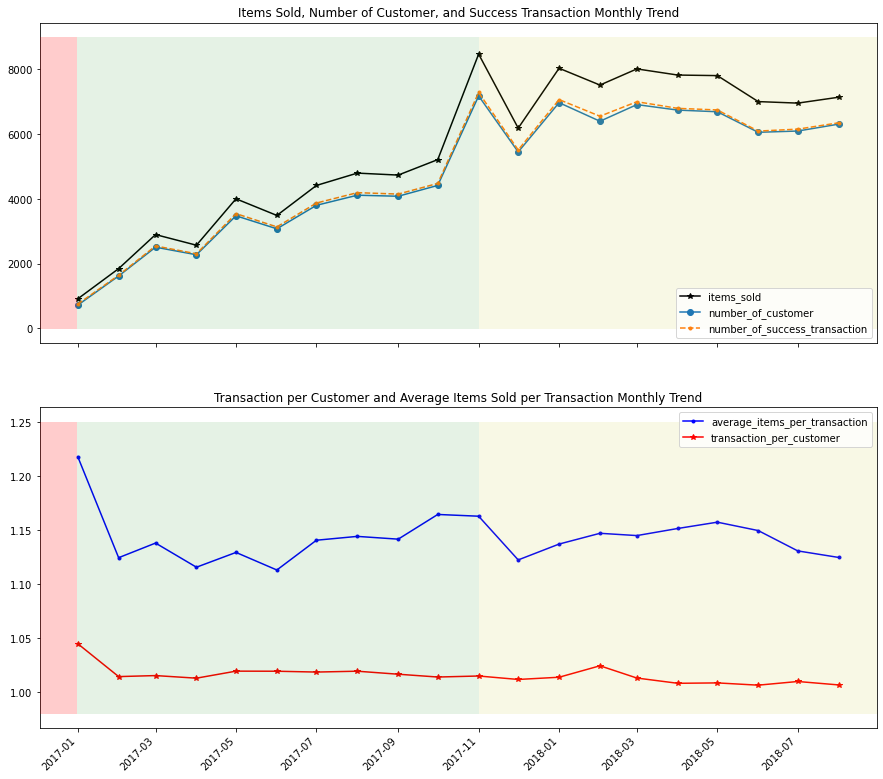

In [923]:
#Define axis
product_sold=data['items_sold']
avg=data['average_items_per_transaction']
transaction=data['number_of_success_transaction']
customer=data['number_of_customer']
trans_per_cus=data['transaction_per_customer']

#Create plot using matplotlib
fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1)
fig.autofmt_xdate(rotation=45)
fig.set_figheight(10)
fig.set_figwidth(15)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.01)
ax1.plot(product_sold,label='items_sold',marker='*',color='k',)
ax1.plot(customer,label='number_of_customer',linestyle='-',marker='o')
ax1.plot(transaction,label='number_of_success_transaction',linestyle='--',marker='.')
ax1.legend()
ax1.set_title('Items Sold, Number of Customer, and Success Transaction Monthly Trend')
ax1.axhspan(-10,9000,xmin=0,xmax=0.045, facecolor='r', alpha=0.2,zorder=3)
ax1.axhspan(-10,9000,xmin=0.045,xmax=0.525, facecolor='g', alpha=0.1,zorder=3)
ax1.axhspan(-10,9000,xmin=0.525,xmax=1, facecolor='y', alpha=0.1,zorder=3)
ax2.plot(avg,label='average_items_per_transaction',marker='.',color='b')
ax2.plot(trans_per_cus,label='transaction_per_customer',marker='*',color='r')
ax2.legend()
ax2.set_title('Transaction per Customer and Average Items Sold per Transaction Monthly Trend')
ax2.axhspan(0.98,1.25,xmin=0,xmax=0.045, facecolor='r', alpha=0.2,zorder=3)
ax2.axhspan(0.98,1.25,xmin=0.045,xmax=0.525, facecolor='g', alpha=0.1,zorder=3)
ax2.axhspan(0.98,1.25,xmin=0.525,xmax=1, facecolor='y', alpha=0.1,zorder=3)


*There are 3 product life cycle stages in olist:
1. Introduction Stage (October 2016 - January 2017)
2. Growth Stage (January 2017 - November 2017)
3. Maturity Stage (November 2017 - July 2018)

*Intoduction Stage
Jumlah transaksi, customer, dan product terjual masih rendah. Akan tetapi apabila dilihat dari transaction behaviournya, ada kenaikan frekuensi transaksi per customer dan jumlah produk yang dipesan yang relatif tinggi.

*Growth Stage
Pada tahap ini, terjadi kenaikan jumlah customer diikuti dengan kenaikan transaksi dan product yang terjual. Apabila melihat stagnansi pada pada customer transaction behaviournya, growth dari transaksi dan product sold diduga dipengaruhi oleh kenaikan jumlah customer.

*Maturity Stage
Pada tahap ini terjadi stagnansi jumlah customer. Apabila melihat dari behaviournya, stagnansi jumlah customer mempengaruhi stagnansi produk terjual dan jumlah transaksi.

<AxesSubplot:xlabel='month_year'>

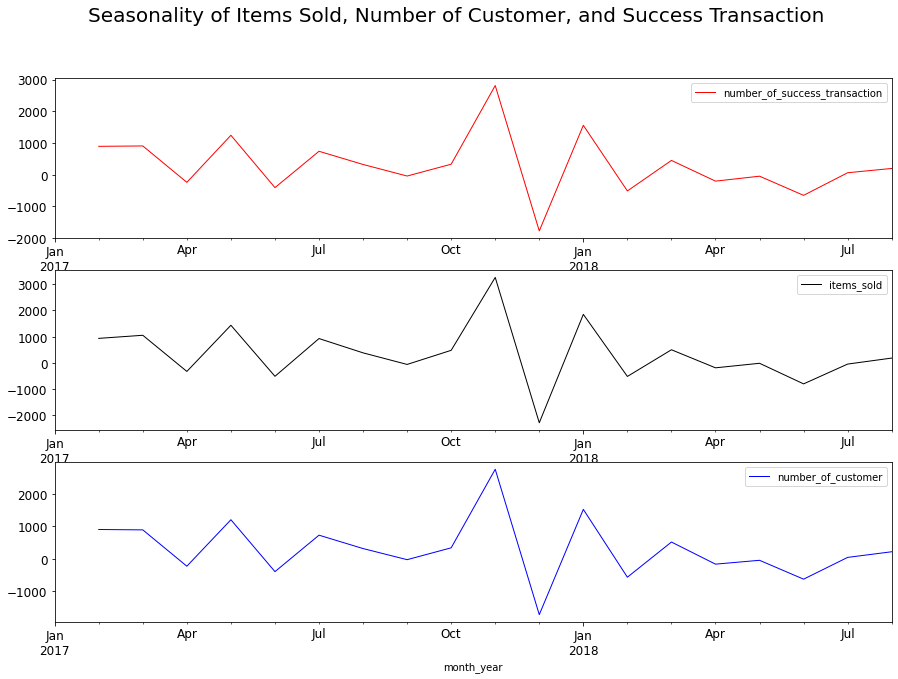

In [974]:
fig,(ax4,ax5,ax6)=plt.subplots(nrows=3,ncols=1,figsize=(15,10))
fig.suptitle('Seasonality of Items Sold, Number of Customer, and Success Transaction ',fontsize=20)
transaction_trend=data[['number_of_success_transaction']]
seasonality=transaction_trend.diff()
seasonality.plot(linewidth=1,fontsize=12,ax=ax4,color='r')
product_sold_trend=data[['items_sold']]
seasonality_produc_sold=product_sold_trend.diff()
seasonality_produc_sold.plot(linewidth=1,fontsize=12,ax=ax5,color='k')
customer_trend=data[['number_of_customer']]
seasonality_customer=customer_trend.diff()
seasonality_customer.plot(linewidth=1,fontsize=12,ax=ax6,color='b')

In [991]:
transaction_growth_november=seasonality['number_of_success_transaction']['2017-11-01']/data['number_of_success_transaction']['2017-10-01']
customer_growth_november=seasonality_customer['number_of_customer']['2017-11-01']/data['number_of_customer']['2017-10-01']
item_growth_november=seasonality_produc_sold['items_sold']['2017-11-01']/data['items_sold']['2017-10-01']
transaction_growth_des=seasonality['number_of_success_transaction']['2017-12-01']/data['number_of_success_transaction']['2017-11-01']
customer_growth_des=seasonality_customer['number_of_customer']['2017-12-01']/data['number_of_customer']['2017-11-01']
item_growth_des=seasonality_produc_sold['items_sold']['2017-12-01']/data['items_sold']['2017-11-01']

print(f'Pada bulan november, transaksi tumbuh sebesar {transaction_growth_november}, jumlah customer tumbuh sebesar {customer_growth_november}, dan produk terjual tumbuh sebsar {item_growth_november}')
print(f'Pada bulan desember, transaksi tumbuh sebesar {transaction_growth_des}, jumlah customer tumbuh sebesar {customer_growth_des}, dan produk terjual tumbuh sebsar {item_growth_des}')



Pada bulan november, transaksi tumbuh sebesar 0.62751228226887, jumlah customer tumbuh sebesar 0.6259904912836767, dan produk terjual tumbuh sebsar 0.6252397391637898
Pada bulan desember, transaksi tumbuh sebesar -0.2435510428100988, jumlah customer tumbuh sebesar -0.24115845168476746, dan produk terjual tumbuh sebsar -0.26988435213594525


There are no seasonality in trend of transaction, product sold, active customer. The best performance of them are in November 2017. The worst performance of them is in November 2017.

#### Total Transaction Per Customer

3. Berapa proporsi customer yang melakukan lebih dari 1 kali?

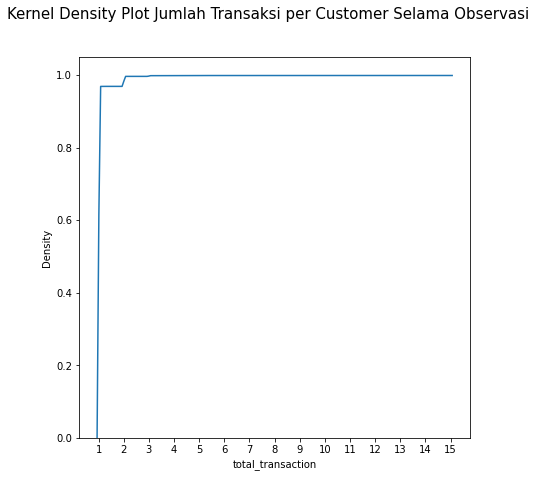

In [995]:
cust_query='''
SELECT 
    cus.customer_unique_id,
    COUNT(ord.order_id) AS total_transaction
FROM 
   olist_order_dataset ord
JOIN
    olist_order_customer_dataset cus
ON 
    cus.customer_id = ord.customer_id
WHERE
    ord.order_approved_at IS NOT NULL AND
    ord.order_delivered_carrier_date IS NOT NULL AND
    ord.order_delivered_customer_date IS NOT NULL AND
    ord.order_status = 'delivered'
GROUP BY
    cus.customer_unique_id

'''
cust=pd.read_sql_query(cust_query,conn)

f,ax= plt.subplots()
f.set_figheight(7)
f.set_figwidth(7)
f.suptitle('Kernel Density Plot Jumlah Transaksi per Customer Selama Observasi',fontsize=15)
sns.kdeplot(cust['total_transaction'],ax=ax,cumulative=True)
ax.set_xticks(range(cust['total_transaction'].min(),cust['total_transaction'].max()+1,1))

Hanya 3.12 % customer yang melakukan transaksi lebih dari 1x. Maka dari itu loyalty dari customer harus ditingkatkan agar transaksi dan produk terjual tetap tumbuh.

In [953]:
repeat_order_table=city_customer_dataset.join(city_repeat_order)
repeat_order_table['repeat_order_customer_percentage']=0
for city in repeat_order_table.index:
    repeat_order_table.loc[city,'repeat_order_customer_percentage']=repeat_order_table.loc[city,'number_of_repeat_order_customer']*100.00/repeat_order_table.loc[city,'number_of_customer']
    


<AxesSubplot:title={'center':'Percentage of Customer that Repeat Order'}, xlabel='repeat_order_customer_percentage', ylabel='customer_city'>

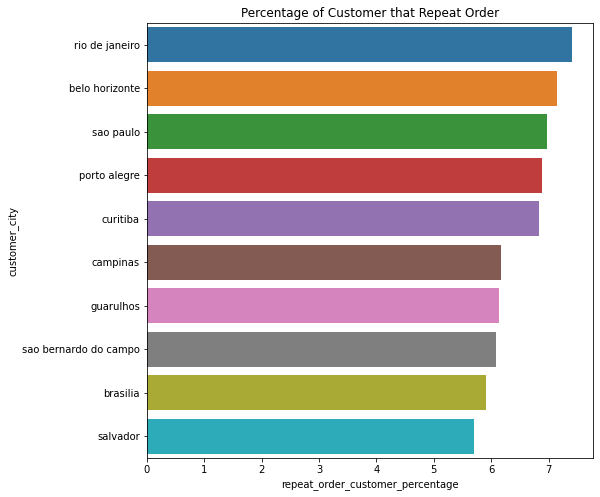

In [1099]:
big_10_ro=repeat_order_table.sort_values('number_of_customer',ascending=False).head(10)
big_10_ro=big_10_ro.sort_values('repeat_order_customer_percentage',ascending=False)
fig,ax=plt.subplots(figsize=(8,8))
ax.set_title('Percentage of Customer that Repeat Order')
sns.barplot(data=big_10_ro,y=big_10_ro.index,x=big_10_ro['repeat_order_customer_percentage'])

## Check Trend Transaction in Each City

4. Kota manakah yang trend pertumbuhan transaksinya tetap positif hingga akhir?

In [152]:
q2='''
SELECT 
    customer_city AS name_of_city,
    (COUNT(customer_unique_id)*100.000)/(
            SELECT 
                COUNT(customer_unique_id) 
            FROM olist_order_customer_dataset
            ) 
        AS percentage_of_customer
FROM
    olist_order_customer_dataset 
GROUP BY
    customer_city
ORDER BY
   percentage_of_customer DESC
'''

<AxesSubplot:title={'center':'10 City with Most Customer'}, xlabel='percentage_of_customer', ylabel='name_of_city'>

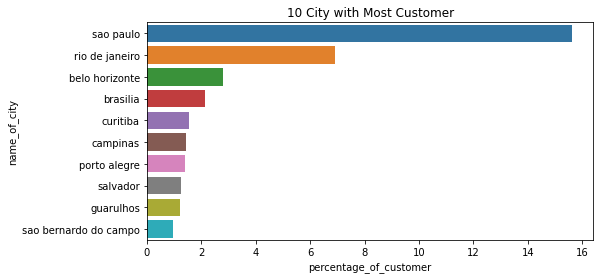

In [153]:
customer=pd.read_sql_query(q2,conn)
fig,axo=plt.subplots(figsize=(8,4))
axo.set_title('10 City with Most Customer')
customer_selected=customer.head(10)
customer_selected
sns.barplot(data=customer_selected, y='name_of_city',x='percentage_of_customer',ax=axo)

### Transaction Trend From Top 10 City with Most Costumer

In [962]:
q3='''
SELECT 
    cust.customer_city,
    COUNT(ord.customer_id) AS transaction_per_region_per_month,
    strftime('%Y-%m-%d',ord.order_purchase_timestamp) AS time
FROM
   olist_order_dataset ord
JOIN
    olist_order_customer_dataset cust
ON
    cust.customer_id = ord.customer_id
WHERE
    ord.order_approved_at IS NOT NULL AND
    ord.order_delivered_carrier_date IS NOT NULL AND
    ord.order_delivered_customer_date IS NOT NULL AND
    ord.order_status = 'delivered'
GROUP BY
    cust.customer_city, time
ORDER BY
    time
'''
list_of_selectedcity=customer_selected['name_of_city'].unique()

In [961]:
trend_cust=pd.read_sql_query(q3,conn)
trend_cust['time']=pd.to_datetime(trend_cust['time'])
trend_cust['month']=pd.DatetimeIndex(trend_cust['time']).month
trend_cust['year']=pd.DatetimeIndex(trend_cust['time']).year
trend_cust

,customer_city,transaction_per_region_per_month,time,month,year
0,sao joaquim da barra,1,2016-09-15,9,2016
1,hortolandia,1,2016-10-03,10,2016
2,ipatinga,1,2016-10-03,10,2016
3,mozarlandia,1,2016-10-03,10,2016
4,panambi,1,2016-10-03,10,2016
...,...,...,...,...,...
58055,salto,1,2018-08-29,8,2018
58056,sao bernardo do campo,1,2018-08-29,8,2018
58057,sao caetano do sul,1,2018-08-29,8,2018
58058,sao jose dos campos,1,2018-08-29,8,2018


In [965]:
for i in trend_cust.index:
    if trend_cust['year'][i] == 2016 or trend_cust['customer_city'][i] not in list_of_selectedcity:
        trend_cust.drop([i],inplace=True)
    else :
        pass

In [970]:
df=trend_cust.groupby(['customer_city','year','month']).agg({'transaction_per_region_per_month':'sum'})
df
df_new=df.unstack(0)
df_new

transaction_per_region_per_month                             \
customer_city                   belo horizonte brasilia campinas curitiba   
year month                                                                  
2017 1                                      16       13        7       38   
     2                                      35       21       28       28   
     3                                      94       51       27       30   
     4                                      64       34       30       21   
     5                                      79       60       37       51   
     6                                      73       66       46       48   
     7                                      95       73       53       53   
     8                                      99       82       69       53   
     9                                      97       94       70       48   
     10                                    123       92       64       53   
     11                                    212      157       89      129   
     12                                    173      129       79       80   
2018 1                                     219      135       91      109   
     2                                     177      170      100      106   
     3                                     217      147      119      110   
     4                                     191      146      103      129   
     5                                     191      140      100       91   
     6                                     183      147      110       96   
     7                                     156      165       72      101   
     8                                     193      143      106      109   

                                                              \
customer_city guarulhos porto alegre rio de janeiro salvador   
year month                                                     
2017 1                6           10             46        6   
     2               13           25            128       18   
     3               30           40            199       26   
     4               35           37            164       29   
     5               33           50            263       43   
     6               36           55            206       29   
     7               47           58            306       54   
     8               41           82            292       53   
     9               46           68            300       49   
     10              54           70            351       53   
     11              69          110            556       88   
     12              60           69            386       91   
2018 1               83           77            470       85   
     2               59           85            491       71   
     3               79           99            408       82   
     4               74           90            410       96   
     5              100           84            417       95   
     6               95           65            352       80   
     7               89           77            382       80   
     8               93           88            446       60   

                                               
customer_city sao bernardo do campo sao paulo  
year month                                     
2017 1                            5        92  
     2                           16       212  
     3                           19       362  
     4                           18       279  
     5                           26       501  
     6                           33       456  
     7                           33       519  
     8                           41       619  
     9                           37       578  
     10                          35       602  
     11                          67      1081  
     12                          52       820  
2018 1                           62      1066  
 

Text(0.5, 1.0, 'Trend of Transaction per Month from 10 City with Most Customer')

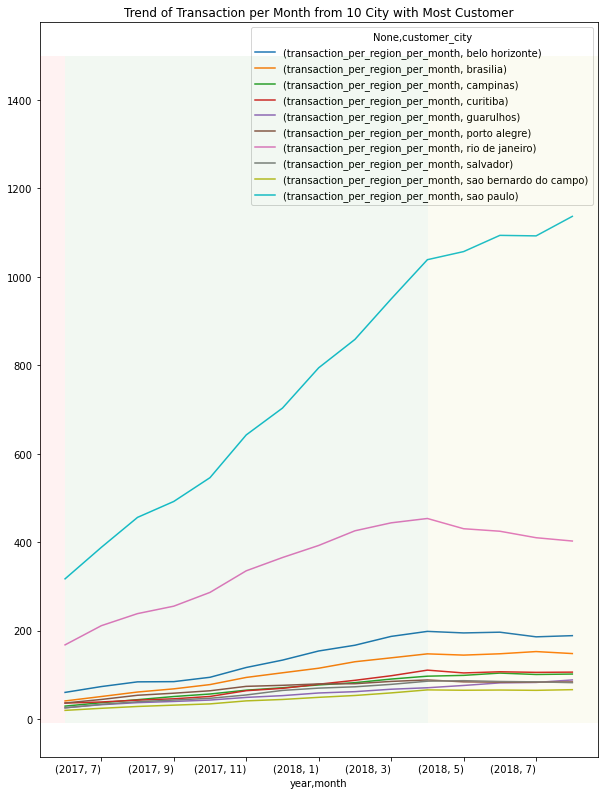

In [969]:
fig,axi=plt.subplots(nrows=1,ncols=1,figsize=(10,15))
fig.autofmt_xdate(rotation=45)
axi.axhspan(-10,1500,xmin=0,xmax=0.045, facecolor='r', alpha=0.05,zorder=10)
axi.axhspan(-10,1500,xmin=0.045,xmax=0.695, facecolor='g', alpha=0.05,zorder=10)
axi.axhspan(-10,1500,xmin=0.695,xmax=1, facecolor='y', alpha=0.05,zorder=10)
df_new=df.unstack(0)
df_new.rolling(6).mean().plot(ax=axi)
plt.title('Trend of Transaction per Month from 10 City with Most Customer')

Need to make different plot because trend of city beside sao paulo and rio de janeiro is not clear.

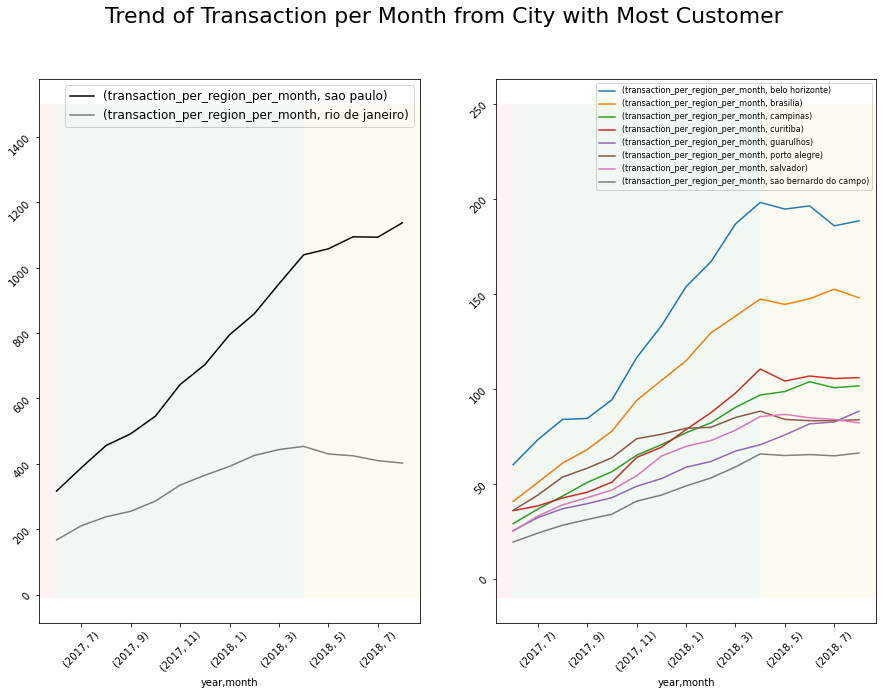

In [1090]:
df_new_low=df_new.drop(columns=[('transaction_per_region_per_month', 'sao paulo'),('transaction_per_region_per_month', 'rio de janeiro')])
df_new_high=df_new[[('transaction_per_region_per_month', 'sao paulo'),('transaction_per_region_per_month', 'rio de janeiro')]]
fig,(ax1, ax2)=plt.subplots(nrows=1,ncols=2,figsize=(15,10))
fig.suptitle('Trend of Transaction per Month from City with Most Customer',fontsize=22)
df_new_low.rolling(6).mean().plot(legend=True, ax=ax2,)
df_new_high.rolling(6).mean().plot(legend=True, ax=ax1,color=['black','grey'])
ax1.axhspan(-10,1500,xmin=0,xmax=0.045, facecolor='r', alpha=0.05,zorder=10)
ax1.axhspan(-10,1500,xmin=0.045,xmax=0.695, facecolor='g', alpha=0.05,zorder=10)
ax1.axhspan(-10,1500,xmin=0.695,xmax=1, facecolor='y', alpha=0.05,zorder=10)
ax1.tick_params(labelrotation=45)
ax1.legend(fontsize=12)
ax2.legend(fontsize=8)
ax2.axhspan(-10,250,xmin=0,xmax=0.045, facecolor='r', alpha=0.05,zorder=10)
ax2.axhspan(-10,250,xmin=0.045,xmax=0.695, facecolor='g', alpha=0.05,zorder=10)
ax2.axhspan(-10,250,xmin=0.695,xmax=1, facecolor='y', alpha=0.05,zorder=10)
ax2.tick_params(labelrotation=45)

As we can see, Sao Paulo and Guarulhos Transaction Trend Grow Positvely all time. Trend of Rio de Janeiro, Belo Horizonte Transaction start to decrease. The other city trend is start to stagnant.

## Predict number of transaction

In [649]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [810]:
#Augmented Dickey-Fuller Test:
result=adfuller(transaction)
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))

Test Statistic: -2.243249
p-value: 0.190925
Critical values:
	1%: -3.859
	5%: -3.042
	10%: -2.661


From the Dickey-Fuller Test it can be conform that transaction data is non-stationary

In [841]:
#Transform the data
transaction_log=np.sqrt(transaction)
transaction_log1=np.sqrt(transaction_log)
transaction_log2=np.sqrt(transaction_log1)
transaction_diff=transaction.diff().dropna()
transaction_diff2=transaction_diff.diff().dropna()

In [858]:
result=adfuller(transaction_diff)
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))

Test Statistic: -7.788240
p-value: 0.000000
Critical values:
	1%: -3.859
	5%: -3.042
	10%: -2.661


After doing difference transformation we can see that data become stationer

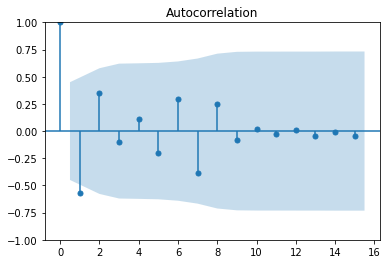

In [996]:
plot_acf(transaction_diff,lags=15);

/Users/ryanalhakim27/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


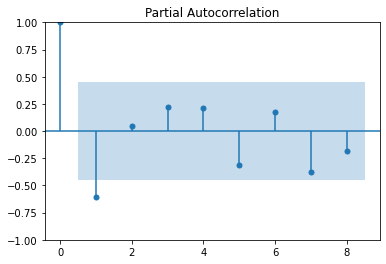

In [997]:
plot_pacf(transaction_diff,lags=8);

/Users/ryanalhakim27/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ryanalhakim27/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ryanalhakim27/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ryanalhakim27/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                     
Dep. Variable:     number_of_success_transaction   No. Observations:                   16
Model:                            ARIMA(1, 3, 1)   Log Likelihood                -111.554
Date:                           Sun, 12 Feb 2023   AIC                            229.108
Time:                                   17:56:22   BIC                            230.803
Sample:                               01-01-2017   HQIC                           228.759
                                    - 04-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8010      0.233     -3.433      0.001      -1.258      -0.344
ma.L1         -0.9989      0.374     -2.671

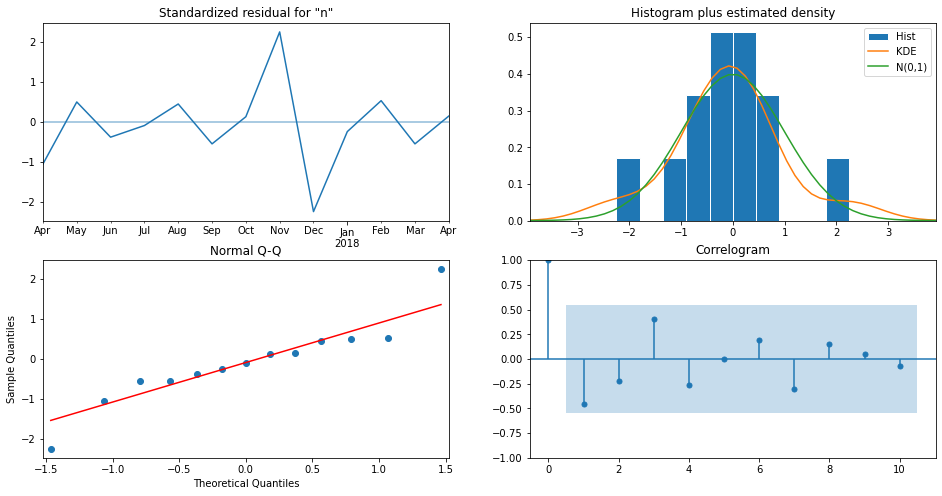

In [1087]:
transaction.index = pd.to_datetime(transaction.index)
train = data['number_of_success_transaction'][:16]
test = data['number_of_success_transaction'][16:]
# p,d,q ARIMA Model
model = ARIMA(train, order=(1,3,1))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [1062]:
#USING AUTOARIMA
#transaction.index = pd.to_datetime(transaction.index)
#train = data['number_of_success_transaction'][:16]
#test = data['number_of_success_transaction'][16:]
#plt.plot(train)
#plt.plot(test)
#arima_model=auto_arima(train,start_p=0, d=1, start_q=0, 
#                       max_p=8, max_d=5, max_q=8,start_P=0, 
#                       D=1, start_Q=0, max_P=5, max_D=8, 
#                       error_action='warn',trace=True,
#                       random_state=20,n_fits=5
#                      )


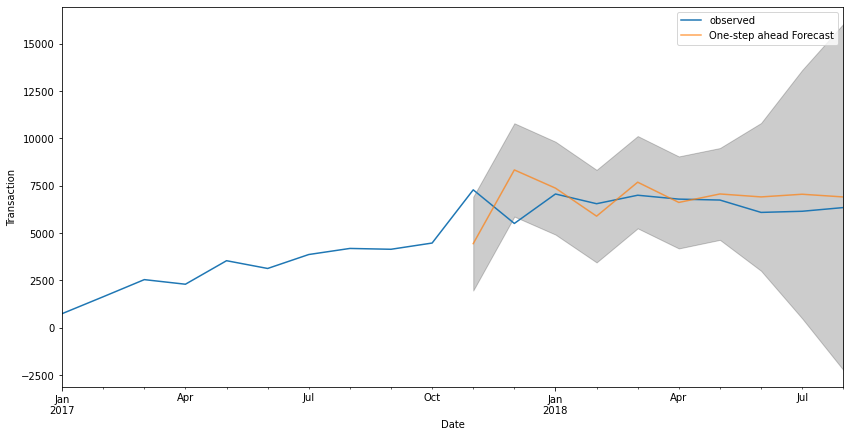

In [1084]:
pred = model_fit.get_prediction(start=pd.to_datetime('2017-11-01'),end=pd.to_datetime('2018-08-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = transaction['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Transaction')
plt.legend()
plt.show()

In [1085]:
y_forecasted = pred.predicted_mean
y_truth = transaction['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 1899211.44
The Root Mean Squared Error of our forecasts is 1378.12


In [1086]:
model_fit.forecast(8)

2018-05-01    7070.221840
2018-06-01    6914.336638
2018-07-01    7055.529801
2018-08-01    6912.914221
2018-09-01    6951.791363
2018-10-01    6799.446031
2018-11-01    6754.430084
2018-12-01    6577.597885
Freq: MS, Name: predicted_mean, dtype: float64

Berdasarkan hasil forecasting terhadap transaksi. Apabila tidak ada intervensi yang dilakukan maka transaksi relatif stagnan hingga akhir tahun 2018.

## Analisa Product Per Region

In [43]:
#Customer Non Sao Paulo
q4 ='''
WITH port_table AS(
SELECT
    itm.order_id ,
    prod.product_category_name
FROM
    olist_order_items_dataset itm
JOIN
    olist_products_dataset prod
ON
    itm.product_id = prod.product_id
), eng_table AS (
SELECT
    por.order_id,
    eng.product_category_name_english AS product_category
FROM
    port_table por
JOIN
    product_category_name_translation eng
ON
    eng.product_category_name = por.product_category_name
),customer_product AS (
SELECT
    od.customer_id,
    et.product_category 
FROM
    eng_table et
JOIN
    olist_order_dataset od
ON
    od.order_id = et.order_id
WHERE 
    od.order_status = 'delivered'
)
SELECT
    DISTINCT ct.customer_city,
    cp.product_category,
    COUNT(cp.product_category) OVER(PARTITION BY product_category, customer_city ) AS number_of_product 
FROM
    customer_product cp
JOIN
    olist_order_customer_dataset ct
ON
    ct.customer_id = cp.customer_id
'''
prod_test=pd.read_sql_query(q4,conn)
prod_test.sort_values('number_of_product',ascending=False)

,customer_city,product_category,number_of_product
3595,sao paulo,bed_bath_table,1950
13961,sao paulo,health_beauty,1715
20735,sao paulo,sports_leisure,1355
15970,sao paulo,housewares,1292
11319,sao paulo,furniture_decor,1238
...,...,...,...
10288,salvador,furniture_bedroom,1
10289,santa barbara d'oeste,furniture_bedroom,1
10290,santa branca,furniture_bedroom,1
10291,santo andre,furniture_bedroom,1
